In [1]:
from functools import partial
from math import pi, sqrt
from plotly import express as px


from ket import *
from ket import ket_version

ket_version()

['Ket v0.9.0b3',
 'libket v0.6.0 [rustc 1.82.0 (f6e511eec 2024-10-15) x86_64-unknown-linux-gnu]',
 'kbw v0.4.0 [rustc 1.82.0 (f6e511eec 2024-10-15) x86_64-unknown-linux-gnu]']

In [2]:
from ket.amazon import AmazonBraket

## Testes

In [3]:
print("Iniciando criação do AmazonBraket...")
try:
    braket = AmazonBraket(num_qubits=2)
    print("AmazonBraket criado com sucesso.")
except Exception as e:
    print(f"Erro ao criar AmazonBraket: {e}")

Iniciando criação do AmazonBraket...
AmazonBraket criado com sucesso.


In [4]:
print("Iniciando braket.connect()...")
try:
    ket_configuration = braket.connect()
    print("braket.connect() executado com sucesso.")
except Exception as e:
    print(f"Erro ao executar braket.connect(): {e}")

Iniciando braket.connect()...
braket.connect() executado com sucesso.


In [5]:
print("Iniciando Process(ket_configuration)...")
try:
    # p = Process(ket_configuration)
    p = Process(braket)
    print("Process criado com sucesso.")
except Exception as e:
    print(f"Erro ao criar Process: {e}")

Iniciando Process(ket_configuration)...
Process criado com sucesso.


## Bell

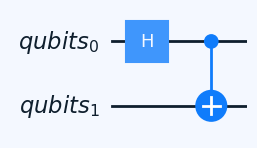

In [6]:
def bell(qubits):
    H(qubits[0])
    CNOT(qubits[0],qubits[1])

qulib.draw(bell, num_qubits=2)

### AmazonBraket

In [7]:
braket = AmazonBraket(num_qubits=2)

p = Process(braket)

qubits = p.alloc(2)

bell(qubits)

sample(qubits).get()

{3: 1001, 0: 1047}

### Ket

In [8]:
p = Process()

qubits = p.alloc(2)

bell(qubits)

sample(qubits, shots=2048).get()

{3: 1041, 0: 1007}

## GHZ

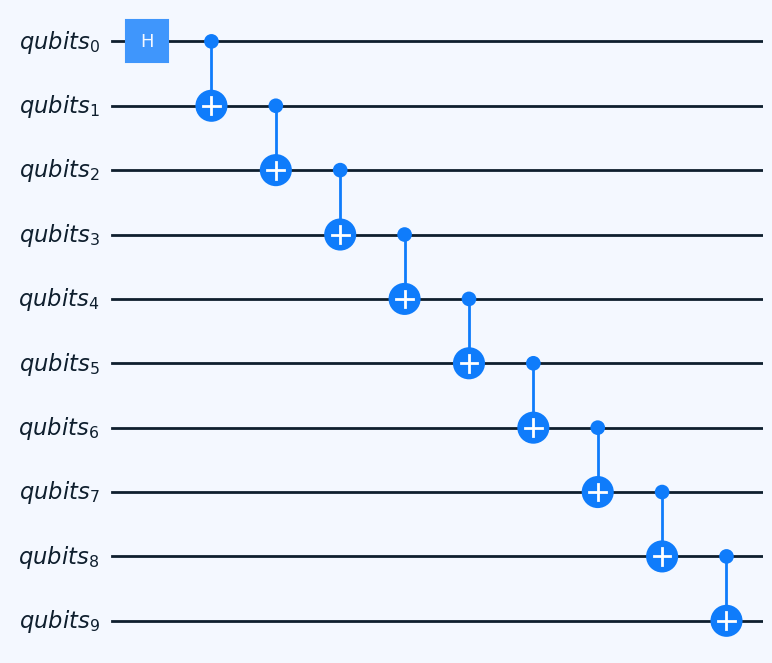

In [9]:
def ghz(qubits):
    H(qubits[0])

    for i in range(len(qubits)-1):
        CNOT(qubits[i], qubits[i+1])

qulib.draw(ghz, num_qubits=10)

### Ket

In [10]:
p = Process()

qubits = p.alloc(10)

ghz(qubits)

sample(qubits).get()

{0: 1023, 1023: 1025}

### AmazonBraket

In [11]:
braket = AmazonBraket(num_qubits=10)

p = Process(braket)

qubits = p.alloc(10)

ghz(qubits)

sample(qubits).get()

{0: 1013, 1023: 1035}

## RXX, RYY, RZZ

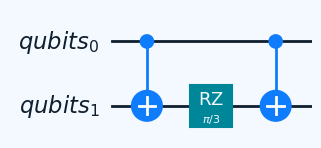

In [12]:
def rxx_circuit(angle, qubits):
    for q in qubits:
        H(q)
    CNOT(qubits[0], qubits[1])
    RZ(angle, qubits[1])
    CNOT(qubits[0], qubits[1])
    for q in qubits:
        H(q)

def ryy_circuit(angle, qubits):
    RX(pi/2, qubits[0])
    RX(pi/2, qubits[1])
    CNOT(qubits[0], qubits[1])
    RZ(angle, qubits[1])
    CNOT(qubits[0], qubits[1])
    RX(pi/2, qubits[1])
    RX(pi/2, qubits[0])

def rzz_circuit(angle, qubits):
    CNOT(qubits[0], qubits[1])
    RZ(angle, qubits[1])
    CNOT(qubits[0], qubits[1])

angle = pi/3

# qulib.draw(rxx_circuit, num_qubits=2, args=(angle,))
# qulib.draw(ryy_circuit, num_qubits=2, args=(angle,))
qulib.draw(rzz_circuit, num_qubits=2, args=(angle,))

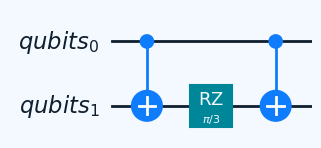

In [13]:
def rxx_circuit(angle, qubits):
    with around(cat(kron(H, H), CNOT), *qubits):
        RZ(angle, qubits[1])

def ryy_circuit(angle, qubits):
    with around(cat(kron(RX(pi/2), RX(pi/2)), CNOT), *qubits):
        RZ(angle, qubits[1])

def rzz_circuit(angle, qubits):
    with around(CNOT, *qubits):
        RZ(angle, qubits[1])

angle = pi / 3

# qulib.draw(rxx_circuit, num_qubits=2, args=(angle,))
# qulib.draw(ryy_circuit, num_qubits=2, args=(angle,))
qulib.draw(rzz_circuit, num_qubits=2, args=(angle,))

### Ket

In [14]:
p = Process()

qubits = p.alloc(2)

angle = pi/3

rxx_circuit(angle, qubits)

sample(qubits).get()

{3: 514, 0: 1534}

### AmazonBraket

In [15]:
braket = AmazonBraket(num_qubits=2)

p = Process(braket)

qubits = p.alloc(2)

angle = pi/3

rxx_circuit(angle, qubits)

sample(qubits).get()

{0: 1527, 3: 521}

## PHASE

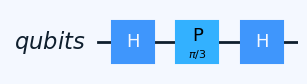

In [16]:
def phase_test(angle, qubits):
    H(qubits)
    P(angle, qubits)
    H(qubits)

qulib.draw(phase_test, num_qubits=1, args=(angle,))

### KET

In [17]:
p = Process()

qubits = p.alloc()

angle = pi/3

phase_test(angle, qubits)

sample(qubits).get()

{0: 1540, 1: 508}

In [18]:
braket = AmazonBraket(num_qubits=2)

p = Process(braket)

qubits = p.alloc()

angle = pi/3

phase_test(angle, qubits)

sample(qubits).get()

{0: 1532, 1: 516}

## QFT

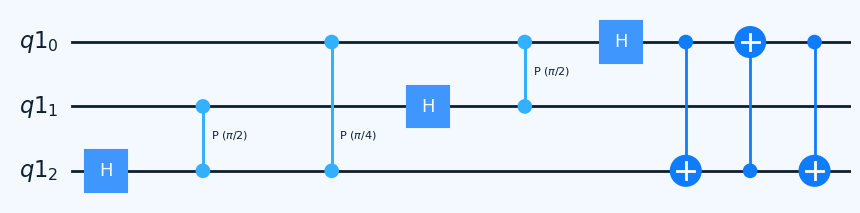

In [19]:
def qft(qubits, do_swap: bool = True):
    if len(qubits) == 1:
        H(qubits)
    else:
        *init, last = qubits
        H(last)

        for i, ctrl_qubit in enumerate(reversed(init)):
            with control(ctrl_qubit):
                P(pi / 2 ** (i + 1), last)

        qft(init, do_swap=False)

    if do_swap:
        size = len(qubits)
        for i in range(size // 2):
            SWAP(qubits[i], qubits[size - i - 1])

qulib.draw(qft, num_qubits=3)

### Ket

In [20]:
p = Process()

qubits = p.alloc(3)

qft(qubits)

sample(qubits).get()

{4: 237, 6: 289, 2: 267, 7: 251, 5: 254, 3: 247, 1: 255, 0: 248}

### AmazonBraket

In [22]:
braket = AmazonBraket(num_qubits=3)

p = Process(braket)

qubits = p.alloc(3)

qft(qubits)

sample(qubits).get()

{3: 257, 5: 242, 0: 266, 4: 244, 1: 261, 7: 254, 6: 257, 2: 267}